# Hiep Pham (s4842104)  
# Individual Project, Type II

# 1. Setups 

In [1]:
!pip install kagglehub
!pip install wordcloud
!pip install --upgrade Pillow
!pip install --upgrade wordcloud

Requirement already up-to-date: Pillow in /opt/conda/lib/python3.8/site-packages (10.4.0)
Requirement already up-to-date: wordcloud in /opt/conda/lib/python3.8/site-packages (1.9.3)


### Imports 

In [2]:
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, ArrayType, StringType, IntegerType, MapType

# 2. Reading the main CSVs from HDFS

Due to some API troubles with ```kagglehub``` and ```Kaggle CLI```, I had to manually download the files. The downloaded folder can be found at [this link](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/). After extracting and moving the files (```credits.csv, keywords.csv, movies_metadata.csv```) to the ```./nbs/data/``` folder, the following commands were used to store the files to HDFS:  

```
docker exec <CONTAINER_ID> hdfs dfs -put /home/nbs/data/credits.csv /credits.csv

docker exec <CONTAINER_ID> hdfs dfs -put /home/nbs/data/keywords.csv /keywords.csv

docker exec <CONTAINER_ID> hdfs dfs -put /home/nbs/data/movies_metadata.csv /movies_metadata.csv
```

with ```<CONTAINER_ID>``` referring to the ID of the container ```namenode``` (courtesy to Assignment 3 setup)

In [5]:
spark = SparkSession.builder.appName('prj') \
                            .getOrCreate()

CREDIT_PATH = 'hdfs://namenode:9000/credits.csv'
MOVIE_PATH = 'hdfs://namenode:9000/movies_metadata.csv'
KEYWORD_PATH = 'hdfs://namenode:9000/keywords.csv'

In [6]:
df_cred = spark.read.option('header', 'true') \
                    .option('inferSchema', 'true') \
                    .option('sep', ',') \
                    .option('quote', '"') \
                    .option('escape', '"') \
                    .option('multiLine', 'true') \
                    .csv('hdfs://namenode:9000/credits.csv')

df_movie = spark.read.option('inferSchema', True) \
                     .option('quote', '"') \
                     .option('escape', '"') \
                     .option('multiLine', True) \
                     .option('sep', ',') \
                     .option('header', True) \
                     .csv(MOVIE_PATH)

df_keywords = spark.read.option('inferSchema', True) \
                        .option('quote', '"') \
                        .option('escape', '"') \
                        .option('multiLine', True) \
                        .option('sep', ',') \
                        .option('header', True) \
                        .csv(KEYWORD_PATH)

# 3. Preprocessing

## 3.1. Movies Data  

### Stringified jsons to jsons

In [7]:
from ast import literal_eval

def string_to_list(entry):
    '''
    Takes a stringified json (a json wrapped in string)
        and transforms it back to its json format.
    @arg entry: The stringified json
    
    @returns List(Dict())
    '''
    try:
        return literal_eval(entry)
    except:
        return []
    
# convert to SQL UDF
string_to_list_udf = F.udf(string_to_list, ArrayType(MapType(StringType(), StringType())))

In [8]:
df_movie = df_movie.withColumn('belongs_to_collection', F.from_json(F.col('belongs_to_collection'), MapType(StringType(), StringType())))
df_movie = df_movie.withColumn('genres', F.from_json(F.col('genres'), ArrayType(MapType(StringType(), StringType()))))
df_movie = df_movie.withColumn('production_companies', F.from_json(F.col('production_companies'), ArrayType(MapType(StringType(), StringType()))))
df_movie = df_movie.withColumn('production_countries', F.from_json(F.col('production_countries'), ArrayType(MapType(StringType(), StringType()))))

df_movie.show(1)

+-----+---------------------+--------+--------------------+--------------------+---+---------+-----------------+--------------+--------------------+----------+--------------------+--------------------+--------------------+------------+---------+-------+--------------------+--------+-------+---------+-----+------------+----------+
|adult|belongs_to_collection|  budget|              genres|            homepage| id|  imdb_id|original_language|original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date|  revenue|runtime|    spoken_languages|  status|tagline|    title|video|vote_average|vote_count|
+-----+---------------------+--------+--------------------+--------------------+---+---------+-----------------+--------------+--------------------+----------+--------------------+--------------------+--------------------+------------+---------+-------+--------------------+--------+-------+---------+-----+------------+----------+
|Fal

### ```collection```

In [9]:
# keeping only necessary info
def collection_info(entry):
    if entry is None:
        return {}

#     del entry['poster_path']
#     del entry['backdrop_path']

    return entry

collection_info_udf = F.udf(collection_info, MapType(StringType(), StringType()))
df_collection = df_movie.withColumn('belongs_to_collection', collection_info_udf(F.col('belongs_to_collection')))

**Normalization**

In [10]:
df_collection_movie_id = df_collection.select(F.col('belongs_to_collection.id').alias('collectionID'), F.col('id').alias('movieID'))

# remove NULL
df_collection_movie_id = df_collection_movie_id.filter(F.col('collectionID').isNotNull()) \
                                               .dropDuplicates()


In [11]:
df_collection_info = df_collection.select(F.col('belongs_to_collection.id').alias('collectionID'), F.col('belongs_to_collection.name').alias('collectionName'))
df_collection_info = df_collection_info.filter(F.col('collectionID').isNotNull()) \
                                       .dropDuplicates()

### ```genres```  

In [12]:
df_genre_info = df_movie.withColumn('genres', F.explode('genres')) \
                        .select(F.col('genres.id').alias('genreID'), F.col('genres.name').alias('genreName')) \
                        .dropDuplicates()

In [13]:
df_genre_movie_id = df_movie.withColumn('genres', F.explode('genres')) \
                            .select(F.col('genres.id').alias('genreID'), F.col('id').alias('movieID')) \
                            .dropDuplicates()

### ```production_companies```

In [14]:
df_prod = df_movie.withColumn('production_companies', F.explode('production_companies'))

df_prod_movie_id = df_prod.select(F.col('production_companies.id').alias('prodID'), F.col('id').alias('movieID')) \
                          .dropDuplicates()

df_prod_info = df_prod.select(F.col('production_companies.id').alias('prodID'), F.col('production_companies.name').alias('prodName')) \
                      .dropDuplicates()

### ```production_countries```

In [15]:
df_country = df_movie.withColumn('production_countries', F.explode('production_countries')) \
                     .select(F.col('production_countries.name').alias('countryName'), F.col('id').alias('movieID')) \
                     .dropDuplicates()

### ```movies``` cleaned

In [16]:
df_movie = df_movie.drop('belongs_to_collection', 'genres', 'production_companies', 'production_countries', 'video')

### Update to HDFS

In [17]:
df_movie.write.csv('hdfs://namenode:9000/data/movies.csv', header=True, mode='overwrite')

## Credits Data

### Stringified Jsons

In [18]:
df_cred = df_cred.withColumn('cast', string_to_list_udf(F.col('cast')))
df_cred = df_cred.withColumn('crew', string_to_list_udf(F.col('crew')))

### ```cast``` - actors

In [19]:
def cast_topk(entry, top_k):
    '''
    From each movie, keep only the top k actors of the movie
    
    @arg top_k: int - Number of actors to keep
    @returns List(Dict())
    '''
    if (len(entry) == 0):
        return []

    entry = [cast_dict for cast_dict in entry if cast_dict['order'] <= top_k - 1]

    return entry

cast_topk_udf = F.udf(lambda entry: cast_topk(entry, 20), ArrayType(MapType(StringType(), StringType()))) # to pass arg, 20 actors

df_cast_filtered = df_cred.withColumn('cast', cast_topk_udf(F.col('cast')))

In [20]:
df_cast_movie_id = df_cast_filtered.withColumn('cast', F.explode('cast')) # each cast is a separate entry
df_cast_movie_id = df_cast_movie_id.select(F.col('cast.id').alias('castID'), F.col('id').alias('movieID')) \
                                   .dropDuplicates()

In [21]:
df_cast = df_cast_filtered.withColumn('cast', F.explode('cast')) \
                          .select(F.col('cast.name').alias('castName'), F.col('cast.id').alias('castID')) \
                          .dropDuplicates(['castID'])

#### Upload to HDFS

In [95]:
df_cast.write.csv('hdfs://namenode:9000/data/cast.csv', header=True)

### ```crew``` - director

In [22]:
# Keeps only "director" role
def crew_director(entry):
    entry = [crew_dict for crew_dict in entry if crew_dict['job'] == 'Director']

    return entry

crew_director_udf = F.udf(crew_director, ArrayType(MapType(StringType(), StringType())))
df_director = df_cred.withColumn('director', crew_director_udf(F.col('crew')))

# normalization
df_director_movie_id = df_director.withColumn('director', F.explode('director')) # each crew (director) is a separate entry
df_director_movie_id = df_director_movie_id.select(F.col('director.id').alias('directorID'), F.col('id').alias('movieID')) \
                                           .dropDuplicates()


In [23]:
df_director_info = df_director.withColumn('director', F.explode('director')) \
                              .select(F.col('director.name').alias('directorName'), F.col('director.id').alias('directorID')) \
                              .dropDuplicates(['directorID'])

#### Upload to HDFS

In [96]:
df_director_info.write.csv('hdfs://namenode:9000/data/director.csv', header=True)

# 4. Query + Viz

## 4.1 View creations for querying

In [25]:
# Main Tables
df_movie.createOrReplaceTempView('movie')
df_cast.createOrReplaceTempView('cast')
df_director_info.createOrReplaceTempView('director')
df_collection_info.createOrReplaceTempView('collection')
df_country.createOrReplaceTempView('country')
df_genre_info.createOrReplaceTempView('genre')
df_prod_info.createOrReplaceTempView('prod')

# Connecting tables
df_cast_movie_id.createOrReplaceTempView('cast_link')
df_director_movie_id.createOrReplaceTempView('director_link')
df_collection_movie_id.createOrReplaceTempView('collection_link')
df_genre_movie_id.createOrReplaceTempView('genre_link')
df_prod_movie_id.createOrReplaceTempView('prod_link')

## 4.2 Queries

In [26]:
# TEST
toy_story_movies = spark.sql(
'''
SELECT m.title, c.collectionName
FROM movie m, collection c, collection_link cl
WHERE m.id = cl.movieID AND cl.collectionID = c.collectionID
                        AND c.collectionName = 'Toy Story Collection'
'''
)
test_df = toy_story_movies.toPandas()
test_df

,title,collectionName
0,Toy Story,Toy Story Collection
1,Toy Story 2,Toy Story Collection
2,Toy Story 3,Toy Story Collection


### Highest grossing franchise (collection)

In [49]:
pip install plotly

     |████████████████████████████████| 19.1 MB 21.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [58]:
import plotly.express as px
import pandas as pd
import random

In [48]:
# best_franchise 
best_franchise = spark.sql(
'''
SELECT 
    c.collectionName AS collectionName,
    i.totalRevenue AS totalRevenue,
    i.averageRating AS averageRating,
    i.movieCount AS movieCount
    
FROM 
    collection c
JOIN 
    (
    SELECT 
        cl.collectionID as cID,
        SUM(m.revenue) AS totalRevenue,
        AVG(m.vote_average) AS averageRating,
        COUNT(m.id) AS movieCount

    FROM
        collection_link cl
    JOIN 
        movie m ON cl.movieID = m.id
        
    WHERE
        m.revenue > 0

    GROUP BY cl.collectionID
    ) AS i
    ON c.collectionID = i.cID
    
ORDER BY 
    totalRevenue DESC

'''
)
best_franchise.show(20, truncate=False)

+-----------------------------------+------------+-----------------+----------+
|collectionName                     |totalRevenue|averageRating    |movieCount|
+-----------------------------------+------------+-----------------+----------+
|Harry Potter Collection            |7707367425  |7.5375           |8         |
|Star Wars Collection               |7434494790  |7.374999999999999|8         |
|James Bond Collection              |7106970239  |6.338461538461539|26        |
|The Fast and the Furious Collection|5125098793  |6.6625           |8         |
|Pirates of the Caribbean Collection|4521576826  |6.88             |5         |
|Transformers Collection            |4366101244  |6.14             |5         |
|Despicable Me Collection           |3691070216  |6.675            |4         |
|The Twilight Collection            |3342107290  |5.839999999999999|5         |
|Ice Age Collection                 |3216708553  |6.38             |5         |
|Jurassic Park Collection           |303

- The *Harry Potter* franchise raked in more than \$7.7b across 8 movies, coming at first, while *Star Wars* franchise is a close second at \$7.4b with 8 movies as well. The *James Bond* collection, despite having 26 movies in total, made a total \$7.1b in revenue at 3rd place.

In [90]:
def plot_franchise(top_k):
    best_franchise_df = best_franchise.limit(top_k).toPandas()

    # color for random color
    best_franchise_df['color'] = [f'rgb({random.randint(0,255)}, {random.randint(0,255)}, {random.randint(0,255)})' for _ in range(len(best_franchise_df))]
    best_franchise_df['totalRevenue'] = best_franchise_df['totalRevenue'] / 1e9

    fig = px.scatter(
        best_franchise_df,
        x='totalRevenue', 
        y='averageRating',
        size='movieCount',  
        hover_name='collectionName',  
        color='collectionName',
        labels={'x': 'Total Revenue (in Billion $)', 'y': 'Average Rating'},  
        title=f'Top {top_k} highest grossing movie franchise'
    )

    # Layout
    fig.update_layout(
        legend_title_text='Franchise',  
        title={'x':0.5, 'xanchor': 'center'},
        xaxis_title="Total Revenue (in Billion $)",  
        yaxis_title="Average Rating",  
        showlegend=True, 
    )

    # Show the plot
    fig.show()

plot_franchise(75)

### Most successful production companies

In [66]:
best_company = spark.sql(
'''
SELECT 
    pr.prodName AS companyName,
    i.movieCount AS movieCount,
    i.totalRevenue AS totalRevenue

FROM 
    prod pr
    
JOIN
    (
    SELECT 
        prl.prodID AS prodID,
        COUNT(m.id) AS movieCount,
        SUM(m.revenue) AS totalRevenue
    FROM
        prod_link prl
    JOIN 
        movie m ON prl.movieID = m.id
    
    WHERE m.revenue > 0

    GROUP BY 
        prl.prodID
    ) AS i
    ON pr.prodID = i.prodID

ORDER BY 
    totalRevenue DESC
'''
)

best_company.show(20, truncate=False)

+--------------------------------------+----------+------------+
|companyName                           |movieCount|totalRevenue|
+--------------------------------------+----------+------------+
|Warner Bros.                          |491       |63525187272 |
|Universal Pictures                    |463       |55259190410 |
|Paramount Pictures                    |395       |48808192922 |
|Twentieth Century Fox Film Corporation|341       |47687746332 |
|Walt Disney Pictures                  |147       |40837270159 |
|Columbia Pictures                     |236       |32279735705 |
|New Line Cinema                       |198       |22173391499 |
|Amblin Entertainment                  |68        |17343720181 |
|DreamWorks SKG                        |78        |15475754744 |
|Dune Entertainment                    |62        |15003789066 |
|Village Roadshow Pictures             |89        |14904700343 |
|Relativity Media                      |115       |14603149665 |
|Touchstone Pictures     

In [91]:
def plot_company(topk):
    best_company_df = best_company.limit(topk).toPandas()

    # scale down
    best_company_df['totalRevenue'] = best_company_df['totalRevenue'] / 1e9 

    # Plot
    fig = px.scatter(
        best_company_df,
        x='totalRevenue',
        y='movieCount',    
        size='totalRevenue', 
        hover_name='companyName', 
        color='companyName',  # Different color for each company
        labels={'totalRevenue': 'Total Revenue (Billion $)', 'movieCount': 'Movie Count'},
        title=f'Top {topk} most successful production companies'
    )

    # Layout
    fig.update_layout(
        xaxis=dict(title='Total Revenue (in Billion $)'),
        yaxis=dict(title='Number of Movies'),
        showlegend=True  
    )

    # Show the plot
    fig.show()
    
plot_company(75)

### Most successful directors

In [83]:
best_director = spark.sql(
'''
SELECT 
    d.directorName AS directorName,
    i.movieCount AS movieCount,
    i.totalMovieRevenue AS totalMovieRevenue,
    i.averageRating AS averageRating

FROM
    director d
JOIN 
    (
    SELECT 
        dl.directorID AS directorID,
        COUNT(m.id) AS movieCount,
        SUM(m.revenue) AS totalMovieRevenue,
        AVG(m.vote_average) AS averageRating

    FROM 
        director_link dl
    JOIN
        movie m ON dl.movieID = m.id

    GROUP BY 
        dl.directorID
    ) AS i
    ON i.directorID = d.directorID

ORDER BY 
    totalMovieRevenue DESC
'''
)

best_director.show(10, truncate=False)

+-----------------+----------+-----------------+------------------+
|directorName     |movieCount|totalMovieRevenue|averageRating     |
+-----------------+----------+-----------------+------------------+
|Steven Spielberg |33        |9256621422       |6.893939393939393 |
|Peter Jackson    |14        |6528244659       |7.121428571428572 |
|Michael Bay      |13        |6437466781       |6.392307692307692 |
|James Cameron    |12        |5900610310       |6.349999999999999 |
|David Yates      |10        |5334563196       |6.029999999999999 |
|Christopher Nolan|11        |4747408665       |7.618181818181818 |
|Robert Zemeckis  |19        |4138233542       |6.794736842105263 |
|Tim Burton       |21        |4032916124       |6.7333333333333325|
|Ridley Scott     |24        |3917529240       |6.604166666666667 |
|Chris Columbus   |15        |3866836869       |6.44              |
+-----------------+----------+-----------------+------------------+
only showing top 10 rows



In [92]:
def plot_director(topk):
    best_director_df = best_director.limit(topk).toPandas()

    # scale down
    best_director_df['totalMovieRevenue'] = best_director_df['totalMovieRevenue'] / 1e9 

    # Plot
    fig = px.scatter(
        best_director_df,
        x='totalMovieRevenue',
        y='movieCount',    
        size='averageRating',  # size proportional to rating
        hover_name='directorName',
        color='averageRating',  
        title=f'Top {topk} most successful directors'
    )

    # Layouyt
    fig.update_layout(
        xaxis=dict(title='Total Revenue from Movies (in Billion $)'),
        yaxis=dict(title='#Movies Directed'),
        showlegend=True 
    )

    # Show the plot
    fig.show()

plot_director(50)

### Actor-Director Combo that results in the highest revenue

In [27]:
best_actor_director = spark.sql(
'''
SELECT
    d.directorName AS director_name,
    c.castName AS actor_name,
    SUM(m.revenue) AS total_revenue

FROM director d
JOIN
    director_link dl ON d.directorID = dl.directorID
JOIN
    movie m ON dl.movieID = m.id
JOIN
    cast_link cl ON m.id = cl.movieID
JOIN
    cast c ON cl.castID = c.castID

GROUP BY director_name, actor_name
ORDER BY total_revenue DESC
'''
)
best_actor_director.show(10, truncate=False)

+-----------------+--------------------+-------------+
|director_name    |actor_name          |total_revenue|
+-----------------+--------------------+-------------+
|Peter Jackson    |Ian McKellen        |5852068099   |
|Peter Jackson    |Cate Blanchett      |4893668099   |
|Peter Jackson    |Hugo Weaving        |4893668099   |
|Peter Jackson    |Orlando Bloom       |4830964531   |
|Christopher Nolan|Michael Caine       |4593922257   |
|Peter Jackson    |Andy Serkis         |4487648311   |
|Michael Bay      |Peter Cullen        |4366101244   |
|David Yates      |Alan Rickman        |4168477803   |
|David Yates      |Helena Bonham Carter|4168477803   |
|David Yates      |Daniel Radcliffe    |4168477803   |
+-----------------+--------------------+-------------+
only showing top 10 rows



In [93]:
best_actor_director_df = best_actor_director.limit(100).toPandas()
best_actor_director_df

,director_name,actor_name,total_revenue
0,Peter Jackson,Ian McKellen,5852068099
1,Peter Jackson,Hugo Weaving,4893668099
2,Peter Jackson,Cate Blanchett,4893668099
3,Peter Jackson,Orlando Bloom,4830964531
4,Christopher Nolan,Michael Caine,4593922257
...,...,...,...
95,Christopher Nolan,Christian Bale,2573392527
96,Pierre Coffin,Kristen Wiig,2534339254
97,Pierre Coffin,Chris Renaud,2534339254
98,Pierre Coffin,Dana Gaier,2534339254


### Top "loyal" directors - having directed more than 1 movies, and only for a single production.

In [28]:
# total number of production companies each director has worked with
director_prod_count = spark.sql(
'''
SELECT
    d.directorID AS directorID,
    COUNT(DISTINCT p.prodName) AS nProdCompanies

FROM
    director d

JOIN
    director_link dl ON d.directorID = dl.directorID
JOIN
    movie m ON dl.movieID = m.id
JOIN
    prod_link pl ON m.id = pl.movieID
JOIN
    prod p ON pl.prodID = p.prodID

GROUP BY d.directorID
'''
)

director_prod_count.createOrReplaceTempView('director_prod_count')

In [29]:
director_loyal_movie_count = spark.sql(
'''
SELECT
    dpc.directorID AS directorID,
    COUNT(DISTINCT m.id) AS nMoviesDirected
FROM
    director_prod_count dpc
JOIN
    director_link dl ON dpc.directorID = dl.directorID
JOIN
    movie m ON dl.movieID = m.id

WHERE dpc.nProdCompanies = 1

GROUP BY
    dpc.directorID
HAVING
    COUNT(DISTINCT m.id) > 1
'''
)
director_loyal_movie_count.createOrReplaceTempView('director_loyal_movie_count')

In [30]:
# directors who has only worked with 1 production company (with more than 1 company)
loyal_director = spark.sql(
'''
SELECT DISTINCT
    d.directorName AS directorName,
    dlmc.nMoviesDirected AS nMoviesDirected,
    p.prodName AS production_company

FROM
    director_loyal_movie_count dlmc

JOIN
    director d ON dlmc.directorID = d.directorID
JOIN
    director_link dl ON dlmc.directorID = dl.directorID

JOIN
    movie m ON dl.movieID = m.id
JOIN
    prod_link pl ON m.id = pl.movieID
JOIN
    prod p ON pl.prodID = p.prodID

ORDER BY
    nMoviesDirected DESC
'''
)

loyal_director.show(10, truncate=False)

+---------------------+---------------+------------------------------+
|directorName         |nMoviesDirected|production_company            |
+---------------------+---------------+------------------------------+
|William K.L. Dickson |23             |Edison Manufacturing Company  |
|James H. White       |15             |Edison Manufacturing Company  |
|William Heise        |14             |Edison Manufacturing Company  |
|Les Blank            |11             |Flower Films                  |
|Harun Farocki        |11             |Harun Farocki Filmproduktion  |
|Andy Warhol          |10             |Andy Warhol Films             |
|John Bradshaw        |10             |Chesler/Perlmutter Productions|
|Marcel Pagnol        |9              |Les Films Marcel Pagnol       |
|Ertem Eğilmez        |9              |Arzu Film                     |
|Edwin S. Porter      |9              |Edison Manufacturing Company  |
+---------------------+---------------+------------------------------+
only s

In [94]:
loyal_director_df = loyal_director.limit(100).toPandas()
loyal_director_df

,directorName,nMoviesDirected,production_company
0,William K.L. Dickson,23,Edison Manufacturing Company
1,James H. White,15,Edison Manufacturing Company
2,William Heise,14,Edison Manufacturing Company
3,Harun Farocki,11,Harun Farocki Filmproduktion
4,Les Blank,11,Flower Films
...,...,...,...
95,Keiichi Ozawa,4,Nikkatsu
96,J. Stuart Blackton,4,Vitagraph Company of America
97,Chen Kuo-Fu,4,Columbia Pictures Film Production Asia
98,Alex Jones,4,Alex Jones Productions


### Most common themes amongst actors / directors

In [31]:
def get_movies_from_actor(actor_name):
    movies_from_actor = spark.sql(
    f'''
    SELECT
        m.id AS movieID,
        m.title AS movieTitle,
        m.overview AS movieOverview
    FROM movie m
        JOIN cast_link cl ON m.id = cl.movieID
        JOIN cast c ON cl.castID = c.castID
    WHERE c.castName = '{actor_name}'
    '''
    )
    return movies_from_actor

def get_movies_from_director(director_name):
    movies_from_director = spark.sql(
    f'''
    SELECT
        m.id AS movieID,
        m.title AS movieTitle,
        m.overview AS movieOverview
    FROM movie m
        JOIN director_link dl ON m.id = dl.movieID
        JOIN director d ON dl.directorID = d.directorID
    WHERE d.directorName = '{director_name}'
    '''
    )
    return movies_from_director

In [33]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def generate_wordcloud(choice='actor', name='Emma Stone'): 
    if choice == 'director':
        movies = get_movies_from_director(name)
    elif choice == 'actor':
        movies = get_movies_from_actor(name)
    else:
        return
    
    movies_df = movies.toPandas()
    movie_corpus = ' '.join(movies_df['movieOverview'])
    
    movie_wordcloud = WordCloud(
        background_color='white',
        stopwords=STOPWORDS,
        max_words=200,
        height=2000,
        width=4000,
        random_state=42
    ).generate(movie_corpus)

    plt.figure(figsize=(16, 8))
    plt.imshow(movie_wordcloud)
    plt.axis('off')
    plt.show()

#### Most common themes associated with movie director Christopher Nolan

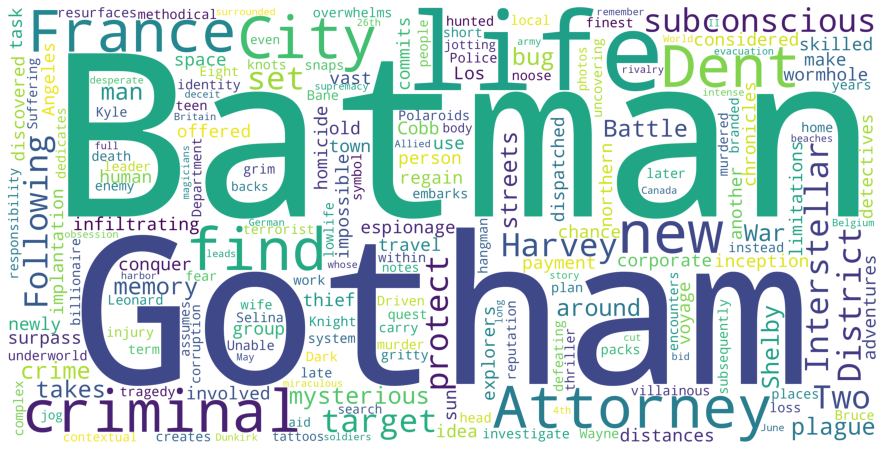

In [36]:
generate_wordcloud('director', 'Christopher Nolan')

#### Most common themes associated with actor Dwayne "The Rock" Johnson

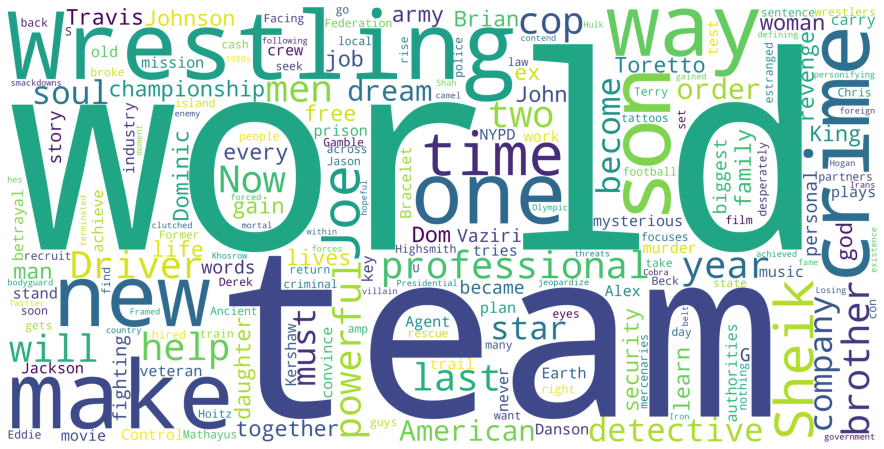

In [37]:
generate_wordcloud('actor', 'Dwayne Johnson')